2024-12-25 16:47:08,806 - INFO - Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
INFO:QSVMClassifier:Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
2024-12-25 16:47:08,807 - INFO - Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
INFO:QSVMClassifier:Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
2024-12-25 16:47:08,830 - INFO - Loaded 2880 samples.
INFO:QSVMClassifier:Loaded 2880 samples.
2024-12-25 16:47:09,546 - INFO - Loaded 2304 training samples and 576 testing samples.
INFO:QSVMClassifier:Loaded 2304 training samples and 576 testing samples.
2024-12-25 16:47:09,547 - INFO - PCA reducing dimensionality to 4 components.
INFO:QSVMClassifier:PCA reducing dimensionality to 4 components.
2024-12-25 16:47:12,712 - INFO - Computing quantum feature maps for training data
INFO:QSVMClassifier:C

Final Accuracy: 0.2378472222222222
Confusion Matrix:
[[27  5  2  5  1  7  3  5  2  9]
 [ 9  9  4  2  4  4 11  7  1  5]
 [ 9 11  5  1  3  5  6  0 12  6]
 [10  3  3  1  3  8  2  6  7  6]
 [17  9  0  5  9  6  3  2  1 15]
 [ 4  3  0  4  3 15  1  9  5  2]
 [ 8 12  2  6  5  8 10  5  3  6]
 [ 6  6  0  6  5  1  7 17  1 13]
 [ 5  2  2  2  1  9  2  0 26  6]
 [ 6  3  1  4  3  5  7  2  3 18]]
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.41      0.32        66
           1       0.14      0.16      0.15        56
           2       0.26      0.09      0.13        58
           3       0.03      0.02      0.02        49
           4       0.24      0.13      0.17        67
           5       0.22      0.33      0.26        46
           6       0.19      0.15      0.17        65
           7       0.32      0.27      0.30        62
           8       0.43      0.47      0.45        55
           9       0.21      0.35      0.26        5

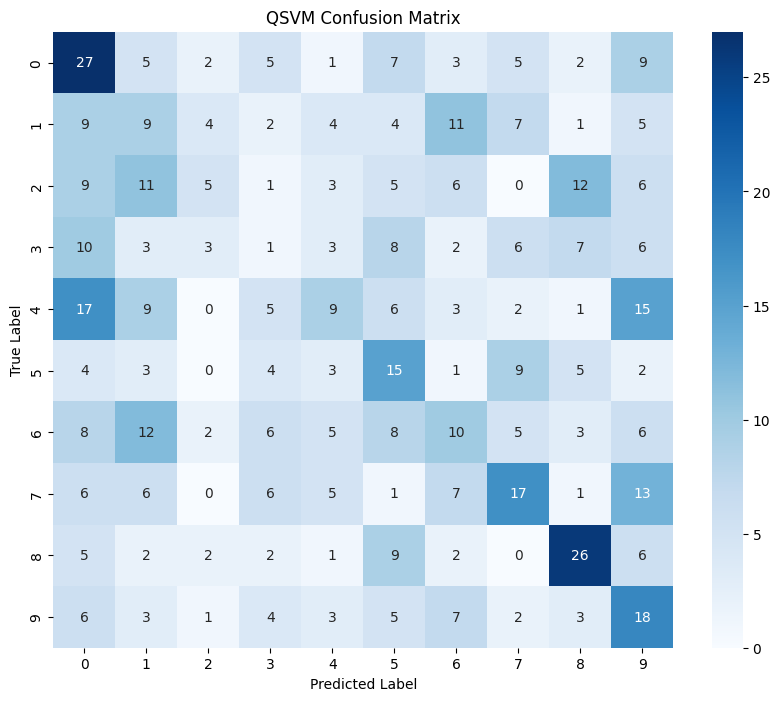

In [4]:
# qsvm_classifier.py

"""
Quantum Support Vector Machine (QSVM) for Nepali Numerals Classification.

This script implements a QSVM using PennyLane and scikit-learn to classify Nepali numerals (0-9)
based on 28x28 pixel grayscale images. The QSVM leverages quantum feature maps to transform
classical data into a quantum-enhanced feature space, followed by a classical SVM for classification.

Directory Structure:
your_project/
├── qsvm_classifier.py
└── data/
    └── numerals/
        ├── 0/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        ├── 1/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        └── ...
        └── 9/
            ├── image1.png
            ├── image2.png
            └── ...
"""

import os
import logging
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pennylane as qml
from pennylane import numpy as pnp
from tqdm import tqdm  # For progress bars
from matplotlib import pyplot as plt
import seaborn as sns

# ==============================
# Reproducibility
# ==============================
def set_random_seeds(seed=42):
    """
    Sets random seeds for reproducibility.

    Args:
        seed (int): The seed value to use.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_random_seeds()

# ==============================
# Logging Setup
# ==============================
def setup_logging(log_file='qsvm_training.log'):
    """
    Sets up logging for the QSVMClassifier.

    Args:
        log_file (str): Path to the log file.

    Returns:
        logging.Logger: Configured logger.
    """
    logger = logging.getLogger('QSVMClassifier')
    logger.setLevel(logging.INFO)

    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(log_file, mode='w')

    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.INFO)

    # Create formatter and add to handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(formatter)
    f_handler.setFormatter(formatter)

    # Add handlers to logger (avoid attaching multiple handlers if re-run)
    if not logger.handlers:
        logger.addHandler(c_handler)
        logger.addHandler(f_handler)

    return logger

logger = setup_logging()

# ==============================
# Dataset Definition
# ==============================
class NepaliMNISTDataset(Dataset):
    """
    Custom Dataset for Nepali Numerals.
    """
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset by loading image paths and labels.

        Args:
            root_dir (str): Root directory containing subdirectories for each numeral.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        logger.info(f"Loading dataset from directory: {root_dir}")
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if not os.path.isdir(label_dir):
                logger.warning(f"Directory for label {label} does not exist: {label_dir}")
                continue
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.data.append(img_path)
                    self.labels.append(label)
        logger.info(f"Loaded {len(self.data)} samples.")

    def __len__(self):
        """
        Returns the total number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the specified index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (image, label)
        """
        image = Image.open(self.data[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ==============================
# Data Transformations
# ==============================
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Ensure consistent image size
    transforms.ToTensor()
])

# ==============================
# Data Loaders Initialization
# ==============================
def initialize_data_loaders(root_dir, batch_size=16):
    """
    Initializes and returns the training and testing data loaders.

    Args:
        root_dir (str): Root directory of the dataset.
        batch_size (int): Number of samples per batch.

    Returns:
        Tuple[DataLoader, DataLoader]: Training and testing data loaders.
    """
    logger.info("Initializing Data Loaders")
    dataset = NepaliMNISTDataset(root_dir=root_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0  # Set to 0 to avoid multiprocessing issues
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    logger.info(f"Data Loaders initialized: {train_size} training samples, {test_size} testing samples")
    return train_loader, test_loader

# ==============================
# Quantum Support Vector Machine (QSVM) Definition
# ==============================
n_qubits = 4  # Number of qubits
n_layers = 3  # Number of entangling layers
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="numpy")
def quantum_kernel(weights, x):
    """
    Quantum feature map for QSVM.

    Args:
        weights (np.array): Weights for entangling layers, shape (n_layers, n_qubits).
        x (np.array): Input data, shape (n_qubits,).

    Returns:
        np.array: Measurement results.
    """
    # Embed classical data into quantum states using Angle Embedding
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation="Y")

    # Apply entangling layers
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))

    # Return expectation values
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def load_real_data(data_dir):
    """
    Load real data from the dataset directory.

    Args:
        data_dir (str): Path to the dataset directory.

    Returns:
        np.array, np.array, np.array, np.array: Training data, training labels, testing data, testing labels.
    """
    logger.info(f"Loading dataset from directory: {data_dir}")
    dataset = NepaliMNISTDataset(root_dir=data_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # Function to extract data from DataLoader
    def extract_data(loader):
        data_list = []
        labels_list = []
        for images, labels in loader:
            # Flatten images: 28x28 -> 784
            flattened = images.view(images.size(0), -1).numpy()
            # Binarize: pixel > 0.5 -> 1, else 0
            flattened = (flattened > 0.5).astype(int)
            data_list.append(flattened)
            labels_list.append(labels.numpy())
        data = np.concatenate(data_list, axis=0)
        labels = np.concatenate(labels_list, axis=0)
        return data, labels

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=len(train_dataset),
        shuffle=False
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=len(test_dataset),
        shuffle=False
    )

    # Extract data
    train_data, train_labels = extract_data(train_loader)
    test_data, test_labels = extract_data(test_loader)

    logger.info(f"Loaded {len(train_data)} training samples and {len(test_data)} testing samples.")
    return train_data, train_labels, test_data, test_labels

def main():
    # Data loading
    data_dir = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # Update with your dataset path
    train_data, train_labels, test_data, test_labels = load_real_data(data_dir)

    # Dimensionality reduction with PCA
    logger.info(f"PCA reducing dimensionality to {n_qubits} components.")
    pca = PCA(n_components=n_qubits)
    train_data_pca = pca.fit_transform(train_data)
    test_data_pca = pca.transform(test_data)

    # Normalize data for Angle Embedding (optional, depends on data scaling)
    # Here, assuming PCA components are already scaled appropriately
    # If not, consider scaling them to [0, pi] for Angle Embedding

    # Initialize quantum kernel parameters
    weights = np.random.random(size=(n_layers, n_qubits))

    # Compute quantum feature maps
    logger.info("Computing quantum feature maps for training data")
    train_features = np.array([quantum_kernel(weights, x) for x in tqdm(train_data_pca, desc="Quantum Kernel - Training")])

    logger.info("Computing quantum feature maps for testing data")
    test_features = np.array([quantum_kernel(weights, x) for x in tqdm(test_data_pca, desc="Quantum Kernel - Testing")])

    # Train classical SVM using quantum kernel features
    logger.info("Training classical SVM using quantum features")
    svm = SVC(kernel="linear")
    svm.fit(train_features, train_labels)

    # Predict and evaluate
    logger.info("Evaluating on test data")
    predictions = svm.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    logger.info(f"Accuracy on test data: {accuracy * 100:.2f}%")
    print("Final Accuracy:", accuracy)

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(test_labels, predictions)
    cr = classification_report(test_labels, predictions, zero_division=0)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

    # Plot Confusion Matrix
    plot_confusion_matrix(cm, classes=[str(i) for i in range(10)], title='QSVM Confusion Matrix')

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """
    Plots the confusion matrix.

    Args:
        cm (np.array): Confusion matrix.
        classes (list): List of class labels.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

if __name__ == "__main__":
    main()
